In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from pyswarms.single.global_best import GlobalBestPSO
import joblib

# Load your datasets
fake_data = pd.read_csv('Fake (1).csv')
true_data = pd.read_csv('True (1).csv')



ModuleNotFoundError: No module named 'seaborn'

In [2]:
# Create label columns (0 for true, 1 for fake)
true_data['label'] = 0
fake_data['label'] = 1
combined_data = pd.concat([true_data, fake_data], ignore_index=True)

# Assuming you have a 'text' column for the text data
X = combined_data['text'].values
y = combined_data['label'].values

# Tokenize and pad the text data
max_words = 10000
max_sequence_length = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_sequence_length)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)



In [3]:
# Define the CNN model for feature extraction
def create_cnn_model(num_filters, kernel_size):
    embedding_dim = 100
    cnn_model = Sequential()
    cnn_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
    cnn_model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(1, activation='sigmoid'))
    cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn_model

# Define the fitness function for PSO
def fitness_function(x):
    num_filters, kernel_size = map(int, x[0][:2])  # Extract the first two elements from the array

    # Ensure num_filters is at least 1
    num_filters = max(num_filters, 1)

    # Ensure kernel_size is at least 1
    kernel_size = max(kernel_size, 1)

    cnn_model = create_cnn_model(num_filters, kernel_size)
    cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    y_pred = cnn_model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Minimize negative accuracy



In [5]:
# Define the PSO optimizer
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
n_particles = 10
dimensions = [(32, 3), (64, 5), (128, 5)]  # Range of filters and kernel sizes to optimize

# Optimize the CNN hyperparameters using PSO
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=len(dimensions), options=options)
best_cost, best_params = optimizer.optimize(fitness_function, iters=10)

# Extract the best hyperparameters
best_params = best_params

# Extract the best_num_filters and best_kernel_size
best_num_filters, best_kernel_size = map(int, best_params[:2])  # Extract the first two elements

# Create and train the final CNN model with the best hyperparameters
best_cnn_model = create_cnn_model(best_num_filters, best_kernel_size)
best_cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)



2024-02-28 10:32:22,247 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|                                                                                |0/10

281/281 [==============================] - 1s 2ms/step


pyswarms.single.global_best:  10%|██████▎                                                        |1/10, best_cost=-.876

281/281 [==============================] - 1s 2ms/step


pyswarms.single.global_best:  20%|████████████▌                                                  |2/10, best_cost=-.876

281/281 [==============================] - 1s 3ms/step


pyswarms.single.global_best:  30%|██████████████████▉                                            |3/10, best_cost=-.947

281/281 [==============================] - 1s 3ms/step


pyswarms.single.global_best:  40%|█████████████████████████▏                                     |4/10, best_cost=-.947

281/281 [==============================] - 1s 2ms/step


pyswarms.single.global_best:  50%|███████████████████████████████▌                               |5/10, best_cost=-.973

281/281 [==============================] - 1s 2ms/step


pyswarms.single.global_best:  60%|█████████████████████████████████████▊                         |6/10, best_cost=-.973

281/281 [==============================] - 1s 3ms/step


pyswarms.single.global_best:  70%|████████████████████████████████████████████                   |7/10, best_cost=-.973

281/281 [==============================] - 1s 2ms/step


pyswarms.single.global_best:  80%|██████████████████████████████████████████████████▍            |8/10, best_cost=-.973

281/281 [==============================] - 1s 2ms/step


pyswarms.single.global_best:  90%|████████████████████████████████████████████████████████▋      |9/10, best_cost=-.973

281/281 [==============================] - 1s 2ms/step


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████|10/10, best_cost=-.973
2024-02-28 10:54:51,497 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.97271714922049, best pos: [2.82679615 1.47132312 1.522603  ]


Epoch 1/20
898/898 [==============================] - 12s 12ms/step - loss: 0.4756 - accuracy: 0.7900 - val_loss: 0.4101 - val_accuracy: 0.8433
Epoch 2/20
898/898 [==============================] - 11s 12ms/step - loss: 0.3867 - accuracy: 0.8500 - val_loss: 0.3749 - val_accuracy: 0.8480
Epoch 3/20
898/898 [==============================] - 11s 12ms/step - loss: 0.3621 - accuracy: 0.8539 - val_loss: 0.3622 - val_accuracy: 0.8504
Epoch 4/20
898/898 [==============================] - 11s 12ms/step - loss: 0.3501 - accuracy: 0.8564 - val_loss: 0.3562 - val_accuracy: 0.8516
Epoch 5/20
898/898 [==============================] - 11s 12ms/step - loss: 0.3426 - accuracy: 0.8592 - val_loss: 0.3502 - val_accuracy: 0.8548
Epoch 6/20
898/898 [==============================] - 11s 12ms/step - loss: 0.3372 - accuracy: 0.8614 - val_loss: 0.3511 - val_accuracy: 0.8559
Epoch 7/20
898/898 [==============================] - 12s 13ms/step - loss: 0.3346 - accuracy: 0.8622 - val_loss: 0.3507 - val_accuracy:

In [8]:
# Save the best-trained CNN model
best_cnn_model.save('best_cnn_model.h5')

# Extract CNN features
X_train_features = best_cnn_model.predict(X_train)
X_test_features = best_cnn_model.predict(X_test)

# Define and train the Decision Tree classifier
# Train the Decision Tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train_features, y_train)

# Save the model
joblib.dump(clf, 'decision_tree_classifier.joblib', compress=('zlib', 3), protocol=4)

# Make predictions
y_pred = clf.predict(X_test_features)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with DT Classifier:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)



C:\Users\hites\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 [==============================] - 1s 2ms/step
Accuracy with DT Classifier: 0.9103563474387528
Confusion Matrix:
 [[4045  285]
 [ 520 4130]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      4330
           1       0.94      0.89      0.91      4650

    accuracy                           0.91      8980
   macro avg       0.91      0.91      0.91      8980
weighted avg       0.91      0.91      0.91      8980



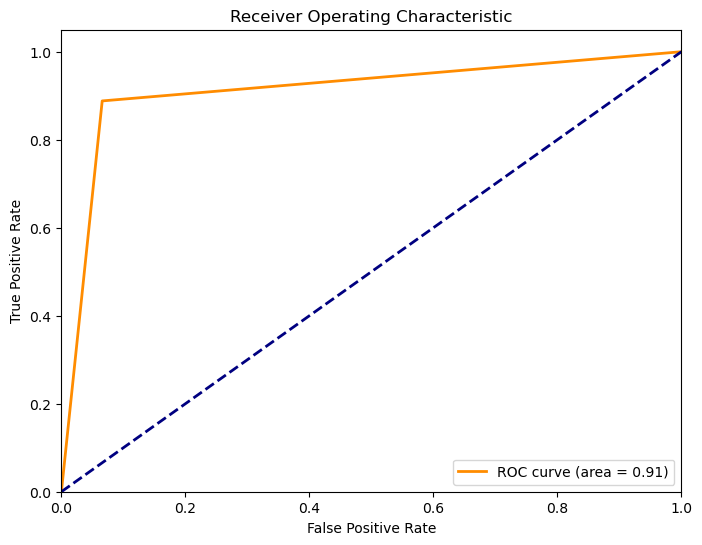

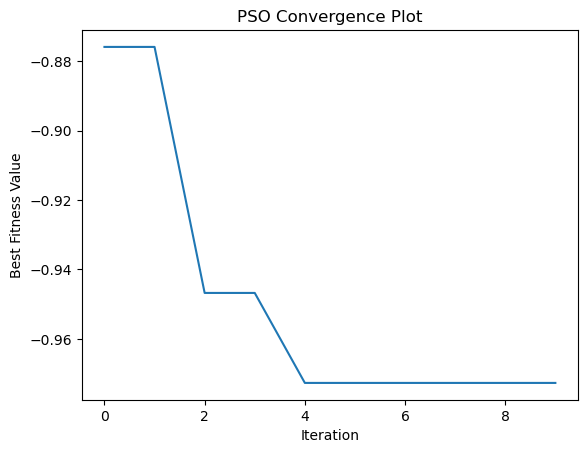

Epoch 1/20
898/898 [==============================] - 11s 12ms/step - loss: 0.1973 - accuracy: 0.9228 - val_loss: 0.2397 - val_accuracy: 0.9060
Epoch 2/20
898/898 [==============================] - 11s 12ms/step - loss: 0.1963 - accuracy: 0.9239 - val_loss: 0.2374 - val_accuracy: 0.9065
Epoch 3/20
898/898 [==============================] - 11s 12ms/step - loss: 0.1955 - accuracy: 0.9238 - val_loss: 0.2386 - val_accuracy: 0.9060
Epoch 4/20
898/898 [==============================] - 11s 12ms/step - loss: 0.1949 - accuracy: 0.9232 - val_loss: 0.2384 - val_accuracy: 0.9056
Epoch 5/20
898/898 [==============================] - 11s 12ms/step - loss: 0.1942 - accuracy: 0.9241 - val_loss: 0.2384 - val_accuracy: 0.9051
Epoch 6/20
898/898 [==============================] - 11s 12ms/step - loss: 0.1937 - accuracy: 0.9234 - val_loss: 0.2377 - val_accuracy: 0.9065
Epoch 7/20
898/898 [==============================] - 11s 12ms/step - loss: 0.1929 - accuracy: 0.9239 - val_loss: 0.2358 - val_accuracy:

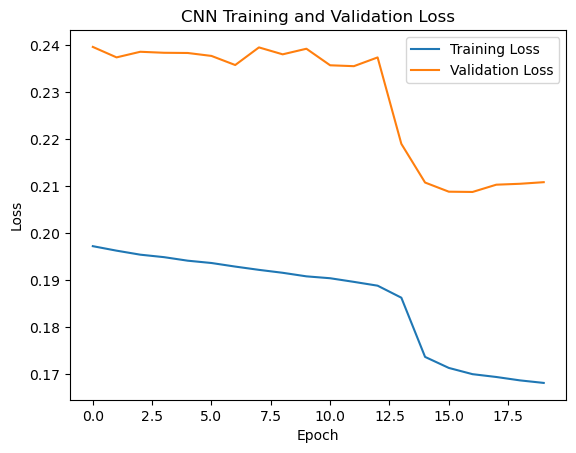

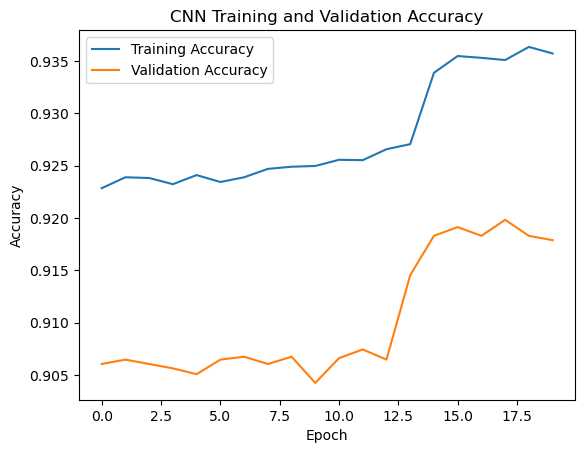

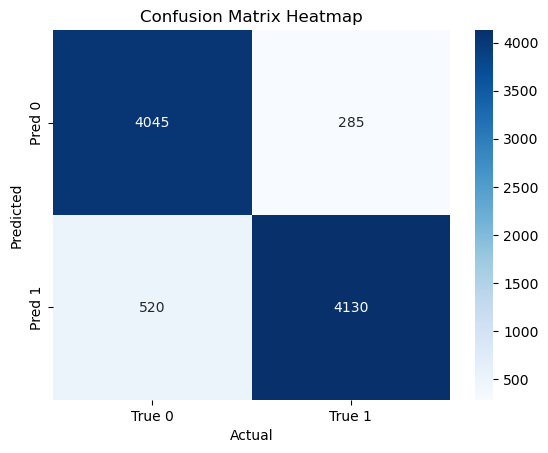

In [9]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Plot Convergence Plot for PSO
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.ylabel('Best Fitness Value')
plt.title('PSO Convergence Plot')
plt.show()


# Plot Training and Validation Loss for CNN
history = best_cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Training and Validation Loss')
plt.show()

# Plot Training and Validation Accuracy for CNN
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Training and Validation Accuracy')
plt.show()

# Plot Confusion Matrix Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['True 0', 'True 1'], yticklabels=['Pred 0', 'Pred 1'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()
